In [1]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from lucent.modelzoo import inceptionv1

In [2]:
# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = inceptionv1(pretrained=True).to(device).eval()

In [3]:
# Load and preprocess a sample image
img_url = "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"
!wget -q {img_url} -O sample.jpg

img = Image.open("sample.jpg").resize((224, 224))

In [4]:
# Preprocessing pipeline (ImageNet normalization)
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(img).unsqueeze(0).to(device)

# Extract feature maps from multiple layers
layer_names = ['conv2d0', 'conv2d2', 'mixed3b', 'mixed4a', 'mixed5b']
feature_maps = {}

def hook_fn(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

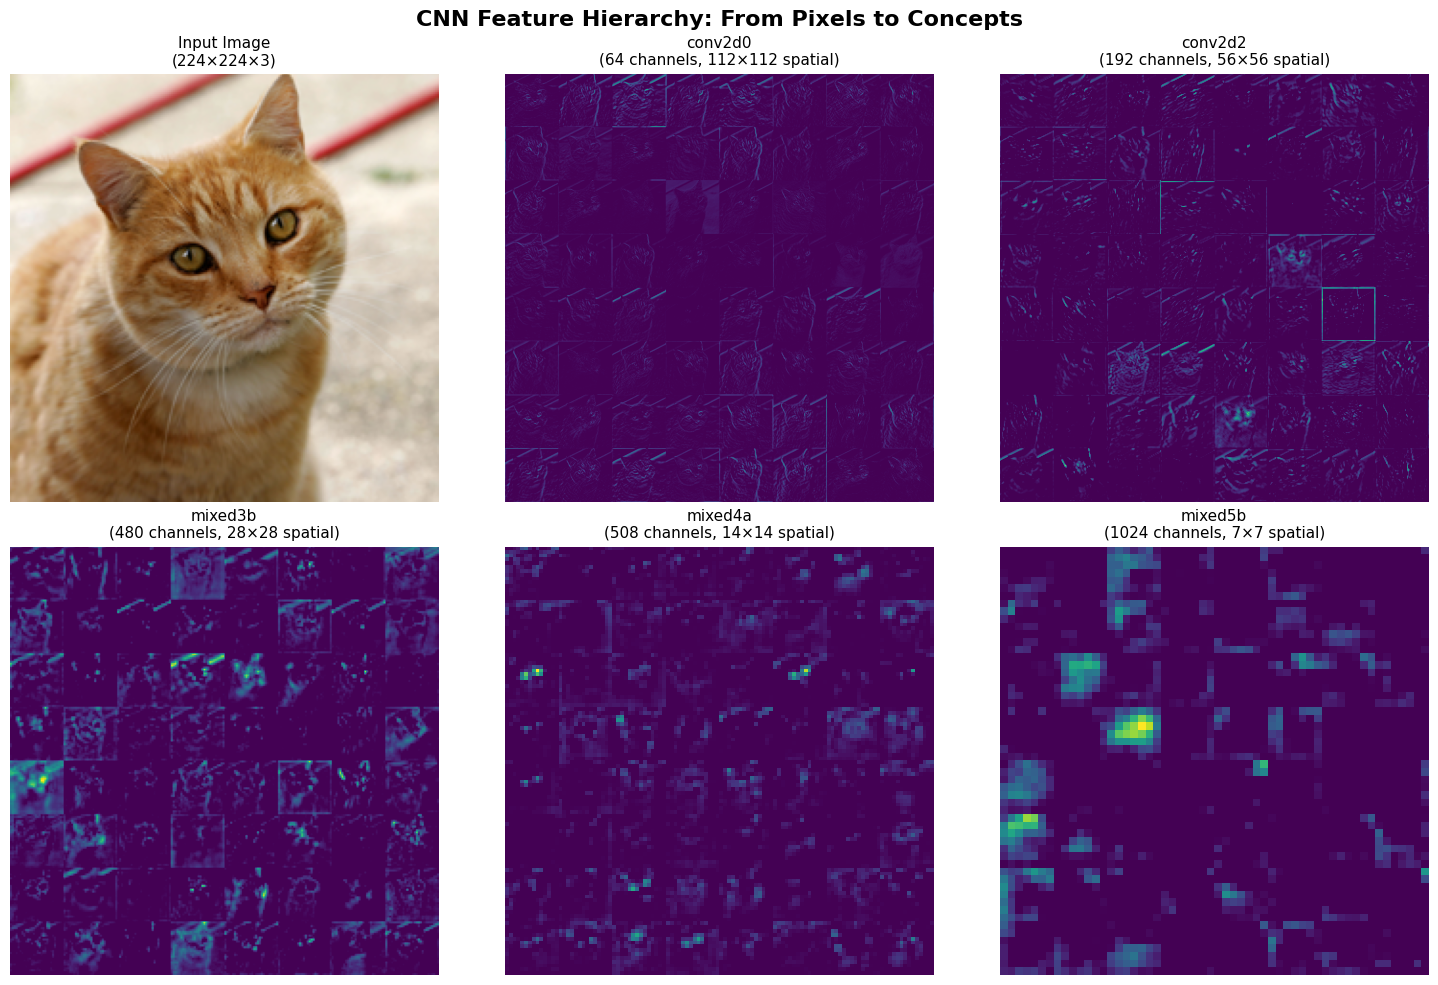

In [5]:
# Register hooks
handles = []
for name, module in model.named_modules():
    if name in layer_names:
        handles.append(module.register_forward_hook(hook_fn(name)))

# Forward pass
with torch.no_grad():
    output = model(img_tensor)
    pred_idx = output.argmax().item()

# Remove hooks
for h in handles:
    h.remove()

# Visualize the transformation
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('CNN Feature Hierarchy: From Pixels to Concepts', fontsize=16, weight='bold')

# Original image
axes[0, 0].imshow(img)
axes[0, 0].set_title('Input Image\n(224×224×3)', fontsize=11)
axes[0, 0].axis('off')

# Feature maps at different depths
positions = [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
for (name, fmap), (i, j) in zip(feature_maps.items(), positions):
    # Show first 64 channels as a grid
    channels = fmap[0].cpu().numpy()
    n_display = min(64, channels.shape[0])
    
    # Create channel grid
    grid_size = int(np.sqrt(n_display))
    grid = np.zeros((grid_size * channels.shape[1], grid_size * channels.shape[2]))
    
    for idx in range(n_display):
        row, col = idx // grid_size, idx % grid_size
        grid[row*channels.shape[1]:(row+1)*channels.shape[1],
             col*channels.shape[2]:(col+1)*channels.shape[2]] = channels[idx]
    
    axes[i, j].imshow(grid, cmap='viridis')
    axes[i, j].set_title(f'{name}\n({fmap.shape[1]} channels, {fmap.shape[2]}×{fmap.shape[3]} spatial)', 
                         fontsize=11)
    axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## Observations:

### Layer-by-Layer Journey

#### **conv2d0:**

An 8×8 grid of tiny cat images, mostly in blue tones. Each small image highlighted different parts - some showed the body outline, some caught the eyes, others picked up the background.

This is the network's first impression. It's breaking down the image into basic building blocks - edges going different directions, color boundaries, simple contrasts.

Each small square is one "feature detector". Some detect vertical lines (cat's legs), others horizontal lines (ground), others diagonal edges (ear curves). They all work together to capture every basic pattern in the image.

---

#### **conv2d2:**

Still recognizable as a cat, but now with greenish highlights. The patterns were more visible and pronounced than before.

The network is starting to combine those basic edges into slightly more complex patterns - like connecting edge pieces to form corners, or combining color boundaries to detect textures.


---

#### **mixed3b:**

Here's where something interesting happened - the highlights got stronger and brighter, but the original cat image started to fade.

The network is becoming **selective**. Instead of responding to everything, it's now interested in *these specific patterns*" and lighting up only where those patterns exist. 

The network is transitioning from "show me everything" to "show me what matters for recognition." Details that don't help identify the cat start to disappear.

---

#### **mixed4a:**

Things started getting blurred. The sharp cat outline was gone, replaced by softer, more diffuse patterns.

We're seeing **abstraction** in action. The network has zoomed out - instead of tracking individual whiskers or fur details, it's tracking larger concepts like "furry texture region" or "curved ear-like shape."

Squinting at the image. You lose detail but keep the important structure - you still know it's a cat, just without seeing individual hairs.

---

#### **mixed5b:**
Very blurred with just a few greenish spots remaining. The original cat image was almost completely gone.

This is nearly the final stage before classification. The network has compressed the entire 224×224 pixel image into just a 7×7 grid of concepts. Those greenish spots might represent ideas like "cat-head-ness here" or "cat-body-ness there."

We've gone from pixels → edges → textures → parts → concepts.

---

First convolutional layer: torch.Size([64, 3, 7, 7])
  → 64 filters
  → Each is 7×7 pixels
  → Operating on 3 input channels (RGB)


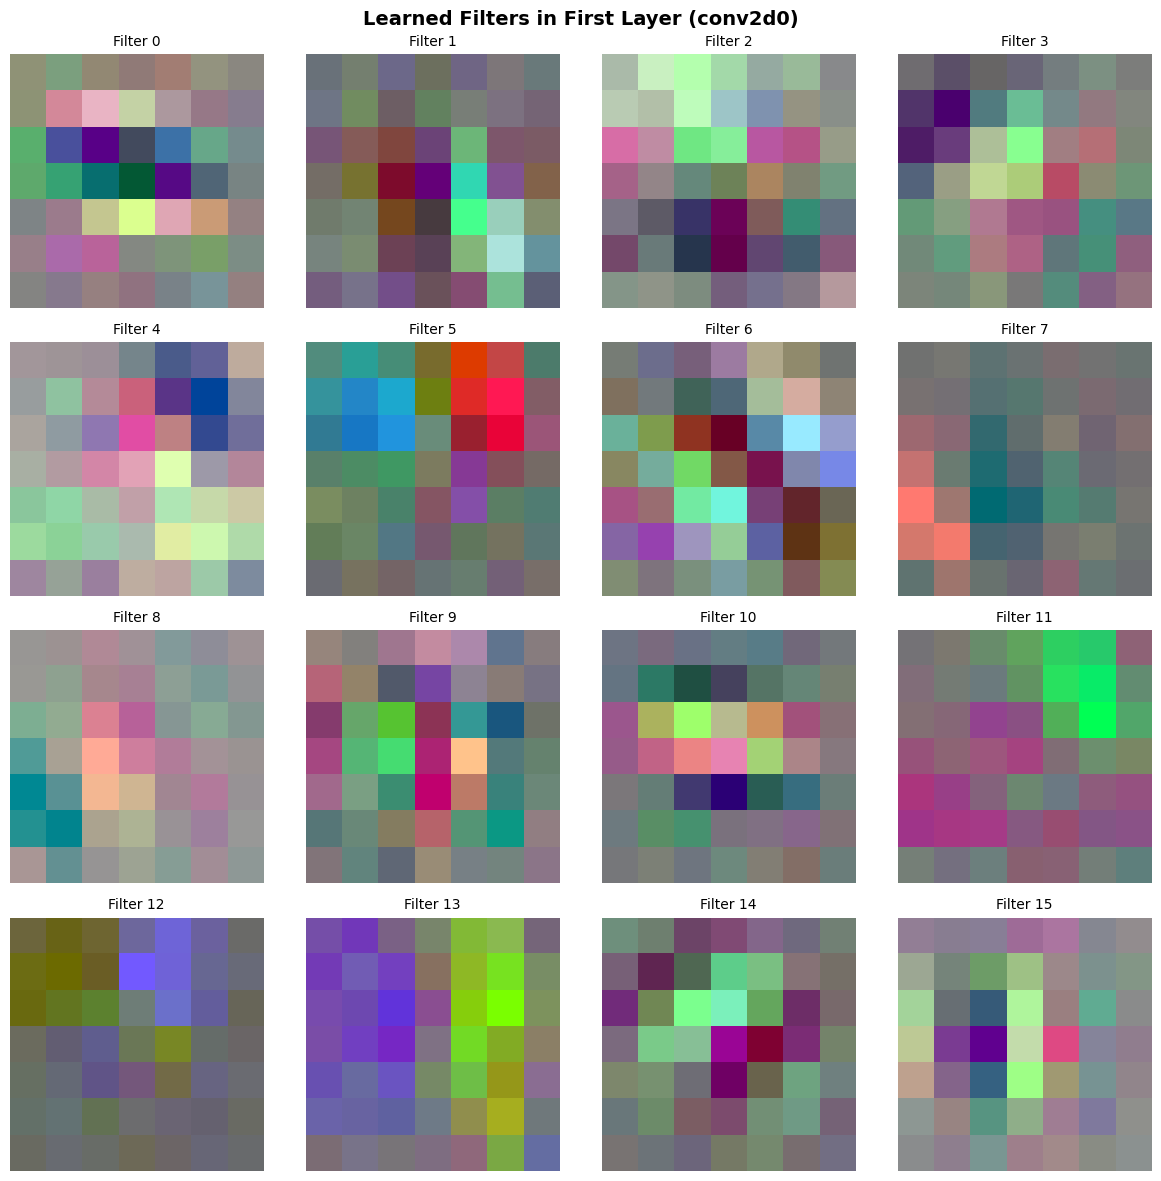

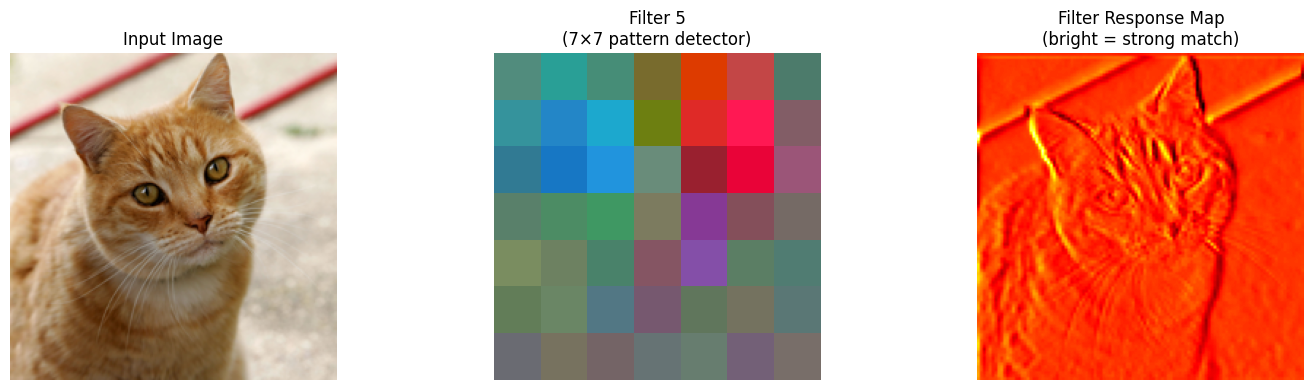

In [6]:
# Visualize actual learned filters from first layer
# Lucent wraps layers, so we need to access the underlying conv layer
first_conv = None
for name, module in model.named_modules():
    if 'conv2d0' in name and isinstance(module, torch.nn.Conv2d):
        first_conv = module
        break

# Alternative: Direct access if above doesn't work
if first_conv is None:
    # Access through the model's internal structure
    first_conv = model._model.Conv2d_1a_7x7.conv

# Get weights: [out_channels, in_channels, height, width]
weights = first_conv.weight.data.cpu()
print(f"First convolutional layer: {weights.shape}")
print(f"  → {weights.shape[0]} filters")
print(f"  → Each is {weights.shape[2]}×{weights.shape[3]} pixels")
print(f"  → Operating on {weights.shape[1]} input channels (RGB)")

# Visualize 16 filters
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Learned Filters in First Layer (conv2d0)', fontsize=14, weight='bold')

for idx in range(16):
    ax = axes[idx // 4, idx % 4]
    
    # Get filter and normalize for visualization
    filt = weights[idx].permute(1, 2, 0).numpy()
    filt = (filt - filt.min()) / (filt.max() - filt.min())
    
    ax.imshow(filt)
    ax.set_title(f'Filter {idx}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Now show how ONE filter responds across the image
sample_filter_idx = 5
single_filter = weights[sample_filter_idx:sample_filter_idx+1]

# Manual convolution to show locality
with torch.no_grad():
    # Just this one filter
    response = torch.nn.functional.conv2d(
        img_tensor,
        single_filter.to(device),
        stride=2,  # InceptionV1's first layer uses stride=2
        padding=3
    )

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original image
axes[0].imshow(img)
axes[0].set_title('Input Image', fontsize=12)
axes[0].axis('off')

# The filter
filt_vis = single_filter[0].permute(1, 2, 0).numpy()
filt_vis = (filt_vis - filt_vis.min()) / (filt_vis.max() - filt_vis.min())
axes[1].imshow(filt_vis)
axes[1].set_title(f'Filter {sample_filter_idx}\n(7×7 pattern detector)', fontsize=12)
axes[1].axis('off')

# Response map
axes[2].imshow(response[0, 0].cpu().numpy(), cmap='hot')
axes[2].set_title('Filter Response Map\n(bright = strong match)', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Key Insight:
The filter is a small template (7x7 pixels), It slides across the entire image (weight sharing)

Bright spots = where the pattern is detected (spatial locality), This happens for ALL 64 filters simultaneously!

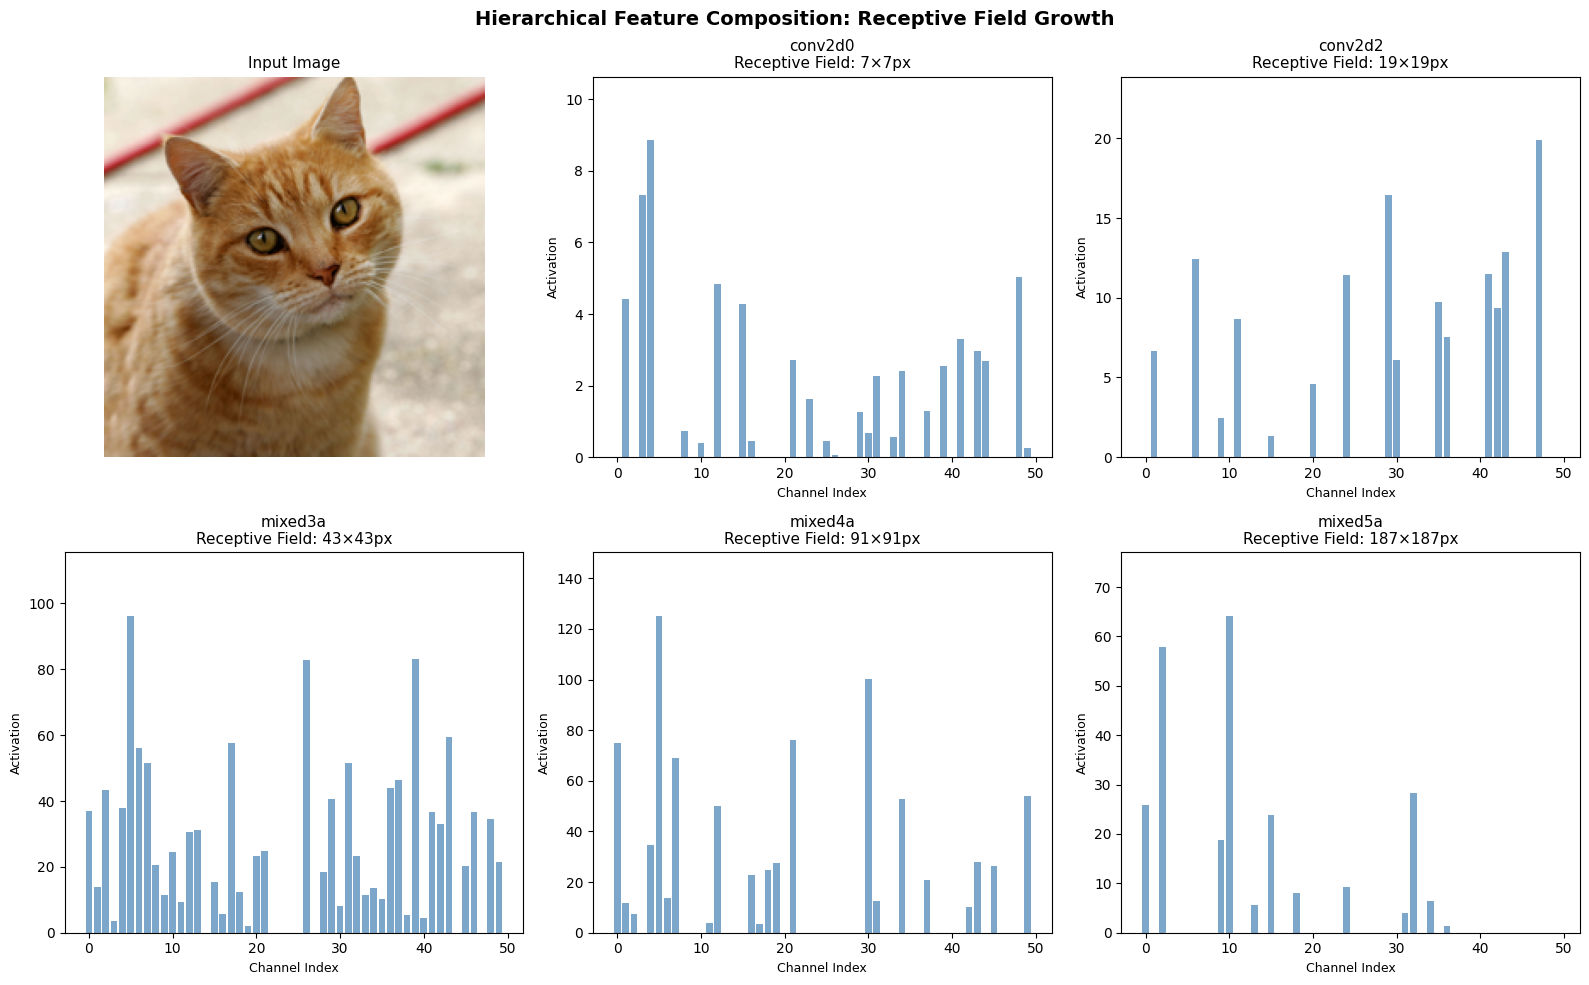

In [7]:
# Trace how a SPECIFIC spatial location evolves through layers
# We'll track the receptive field expansion

def get_activation_path(model, img_tensor, target_layers, spatial_pos=(7, 7)):
    """
    Track how a specific spatial position's activations evolve.
    spatial_pos: (y, x) position in the feature map of the deepest layer
    """
    activations = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook
    
    # Register hooks
    handles = []
    for name, module in model.named_modules():
        if name in target_layers:
            handles.append(module.register_forward_hook(hook_fn(name)))
    
    # Forward pass
    with torch.no_grad():
        _ = model(img_tensor)
    
    # Remove hooks
    for h in handles:
        h.remove()
    
    return activations

layers_to_trace = ['conv2d0', 'conv2d2', 'mixed3a', 'mixed4a', 'mixed5a']
activations = get_activation_path(model, img_tensor, layers_to_trace)

# Visualize how ONE position's receptive field grows
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Hierarchical Feature Composition: Receptive Field Growth', 
             fontsize=14, weight='bold')

# Original image
axes[0, 0].imshow(img)
axes[0, 0].set_title('Input Image', fontsize=11)
axes[0, 0].axis('off')

# Approximate receptive field sizes (for InceptionV1)
receptive_fields = {
    'conv2d0': 7,
    'conv2d2': 19,
    'mixed3a': 43,
    'mixed4a': 91,
    'mixed5a': 187
}

positions = [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
for (layer_name, rf_size), (i, j) in zip(receptive_fields.items(), positions):
    act = activations[layer_name][0].cpu().numpy()
    
    # Take central spatial position
    h, w = act.shape[1] // 2, act.shape[2] // 2
    
    # Show activations across all channels at this position
    channel_values = act[:, h, w]
    
    axes[i, j].bar(range(len(channel_values[:50])), channel_values[:50], 
                   color='steelblue', alpha=0.7)
    axes[i, j].set_title(f'{layer_name}\nReceptive Field: {rf_size}×{rf_size}px', 
                         fontsize=11)
    axes[i, j].set_xlabel('Channel Index', fontsize=9)
    axes[i, j].set_ylabel('Activation', fontsize=9)
    axes[i, j].set_ylim([0, channel_values[:50].max() * 1.2])

plt.tight_layout()
plt.show()

## Key Insight:
Each layer's neuron 'sees' a larger image region than the previous
- conv2d0: Responds to 7×7px patches (edges, colors)
- mixed3a: Responds to 43×43px patches (textures, simple shapes)
- mixed5a: Responds to 187×187px patches (object parts, poses)

Deep neurons combine earlier features to detect complex patterns!

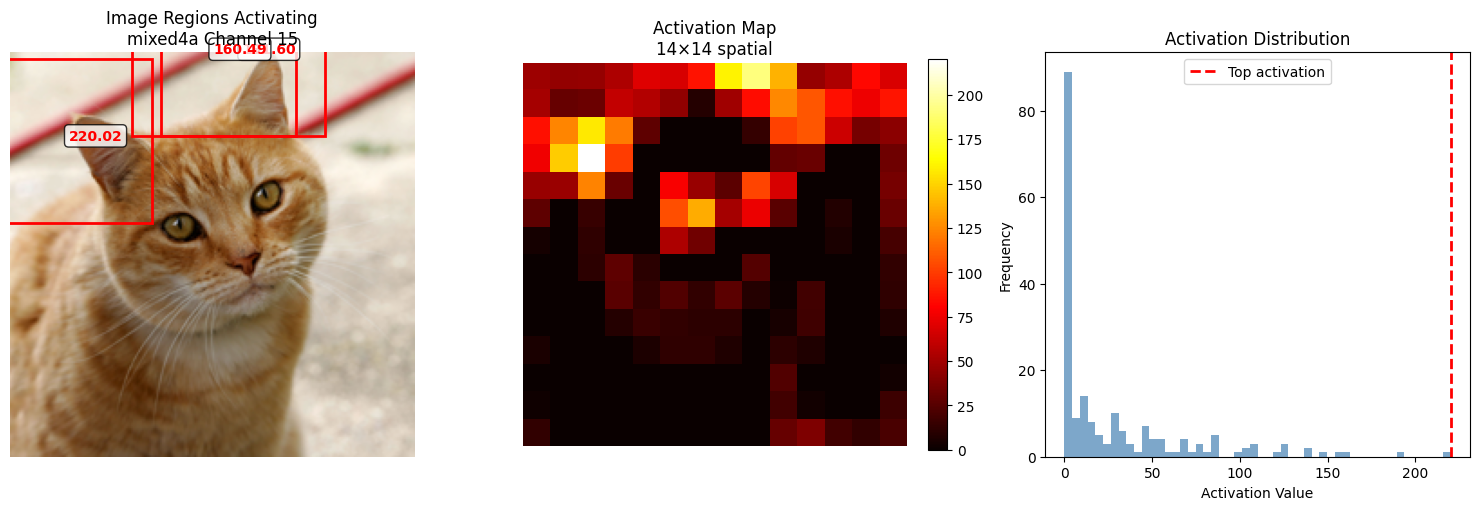

In [8]:
# Find which image regions activate specific neurons most strongly
from matplotlib.patches import Rectangle

def find_top_activating_regions(model, img_tensor, layer_name, channel_idx, top_k=5):
    """Find spatial regions that most strongly activate a specific neuron."""
    activation = {}
    
    def hook(module, input, output):
        activation['output'] = output.detach()
    
    # Hook target layer
    for name, module in model.named_modules():
        if name == layer_name:
            handle = module.register_forward_hook(hook)
            break
    
    # Forward pass
    with torch.no_grad():
        _ = model(img_tensor)
    
    handle.remove()
    
    # Get activations for our channel
    act_map = activation['output'][0, channel_idx].cpu().numpy()
    
    # Find top k positions
    flat_indices = np.argsort(act_map.ravel())[-top_k:][::-1]
    positions = [(idx // act_map.shape[1], idx % act_map.shape[1]) 
                 for idx in flat_indices]
    values = [act_map[y, x] for y, x in positions]
    
    return act_map, positions, values

# Explore a neuron in mixed4a
layer, channel = 'mixed4a', 15

act_map, positions, values = find_top_activating_regions(
    model, img_tensor, layer, channel, top_k=3
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image with receptive fields marked
axes[0].imshow(img)
# Map feature map positions back to input image (rough approximation)
scale_factor = 224 / act_map.shape[0]
rf_size = 91  # Approximate for mixed4a

for (y, x), val in zip(positions, values):
    # Convert to input coordinates
    center_y, center_x = int(y * scale_factor), int(x * scale_factor)
    rect = Rectangle(
        (center_x - rf_size//2, center_y - rf_size//2),
        rf_size, rf_size,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    axes[0].add_patch(rect)
    axes[0].text(center_x, center_y, f'{val:.2f}', 
                 color='red', fontsize=10, weight='bold',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[0].set_title(f'Image Regions Activating\n{layer} Channel {channel}', fontsize=12)
axes[0].axis('off')

# Activation map
im = axes[1].imshow(act_map, cmap='hot', interpolation='nearest')
axes[1].set_title(f'Activation Map\n{act_map.shape[0]}×{act_map.shape[1]} spatial', fontsize=12)
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046)

# Distribution of activations
axes[2].hist(act_map.ravel(), bins=50, color='steelblue', alpha=0.7)
axes[2].axvline(values[0], color='red', linestyle='--', linewidth=2, label='Top activation')
axes[2].set_title('Activation Distribution', fontsize=12)
axes[2].set_xlabel('Activation Value', fontsize=10)
axes[2].set_ylabel('Frequency', fontsize=10)
axes[2].legend()

plt.tight_layout()
plt.show()